In [35]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import scatter_matrix
import seaborn as sns
import plotly.express as px

import scipy.stats as stats

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve, auc as pr_auc, PrecisionRecallDisplay, roc_curve, roc_auc_score, f1_score, precision_score, recall_score, matthews_corrcoef

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import optuna

import lime
from lime.lime_tabular import LimeTabularExplainer
import shap 

import pymc as pm

In [36]:
df = pd.read_csv("dataset/fraud_detection_data.csv")

In [37]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [39]:
# No nulls to handle but dtype 'object' requires handling

In [40]:
df = df[:4000] # For computational ease to significantly reduce df size 

In [41]:
round(df["isFraud"].value_counts()/df.shape[0]*100,2) # Check that dataset reduction has maintained some the minority class

isFraud
0    99.4
1     0.6
Name: count, dtype: float64

In [42]:
obj_cols = df.select_dtypes(include="object")
df[obj_cols.columns] = obj_cols.astype("string")

In [43]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,4000.000000,4.000000e+03,4.000000e+03,4.000000e+03,4.000000e+03,4.000000e+03,4000.000000,4000.0
mean,1.392500,9.728446e+04,9.757329e+05,9.986357e+05,8.040874e+05,9.726647e+05,0.006000,0.0
std,0.614441,2.249773e+05,2.178887e+06,2.226924e+06,2.327466e+06,2.793190e+06,0.077237,0.0
min,1.000000,6.420000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
25%,1.000000,3.980838e+03,4.570000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
50%,1.000000,1.069476e+04,2.568190e+04,1.721129e+04,0.000000e+00,0.000000e+00,0.000000,0.0
75%,2.000000,1.080544e+05,2.700913e+05,2.685557e+05,3.549717e+05,2.679668e+05,0.000000,0.0
max,3.000000,3.776389e+06,1.222588e+07,1.245865e+07,1.951612e+07,1.916920e+07,1.000000,0.0


In [44]:
df = df.drop("isFlaggedFraud", axis=1)

In [45]:
## Data Encoding

In [46]:
# For reference as encode:

df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


In [47]:
df["type"].value_counts()

type
PAYMENT     2077
CASH_IN      818
CASH_OUT     513
TRANSFER     360
DEBIT        232
Name: count, dtype: Int64

In [66]:
# No ordinality observed so to one-hot encode 'type' feature
df_encoded = pd.get_dummies(df, columns=["type"])

In [67]:
# Check 'nameOrig' to determine uniquness

df_encoded["nameOrig"].is_unique

True

In [68]:
# Check whether there's any 'nameOrig' entries that don't involve numbers prefixed with a 'C' followed by a number 
# between 1-9 (ensures that if 'C' is dropped then won't lose any leading zeroes as dtype int) and then the rest numbers

df_encoded[
    ~df_encoded["nameOrig"].str.contains("^C[1-9][0-9]*$", regex=True)
]  

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER


In [69]:
# Remove 'C' prefix

df_encoded["nameOrig"] = df_encoded["nameOrig"].str.replace("C", "").astype("int")

In [70]:
# As with 'nameOrig', check 'nameDest' for any entries not conforming to observed pattern and for any leading zeroes after letter

df_encoded[
    ~df_encoded["nameDest"].str.contains("^[MC][1-9][0-9]*$", regex=True)
]

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER


In [71]:
# Remove prefixes and one-hot encode information as no ordinality present

df_encoded["nameDestLabel"] = df_encoded["nameDest"].str[0]
df_encoded = pd.get_dummies(df_encoded, columns=["nameDestLabel"])
df_encoded["nameDest"] = df_encoded["nameDest"].str.replace("[MC]", "", regex=True).astype("int")

In [72]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   step             4000 non-null   int64  
 1   amount           4000 non-null   float64
 2   nameOrig         4000 non-null   int32  
 3   oldbalanceOrg    4000 non-null   float64
 4   newbalanceOrig   4000 non-null   float64
 5   nameDest         4000 non-null   int32  
 6   oldbalanceDest   4000 non-null   float64
 7   newbalanceDest   4000 non-null   float64
 8   isFraud          4000 non-null   int64  
 9   type_CASH_IN     4000 non-null   bool   
 10  type_CASH_OUT    4000 non-null   bool   
 11  type_DEBIT       4000 non-null   bool   
 12  type_PAYMENT     4000 non-null   bool   
 13  type_TRANSFER    4000 non-null   bool   
 14  nameDestLabel_C  4000 non-null   bool   
 15  nameDestLabel_M  4000 non-null   bool   
dtypes: bool(7), float64(5), int32(2), int64(2)
memory usage: 277

In [73]:
### EDA

In [74]:
## Univariate Analysis

In [75]:
# Select continuous variables
continuous_cols = df_encoded.select_dtypes(include=["int", "float"]).iloc[:,1:-1]


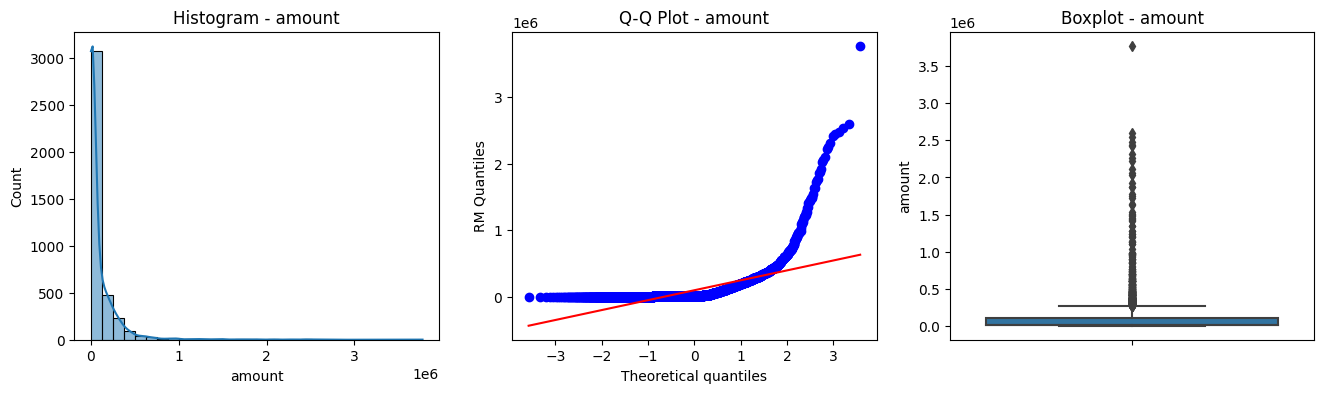

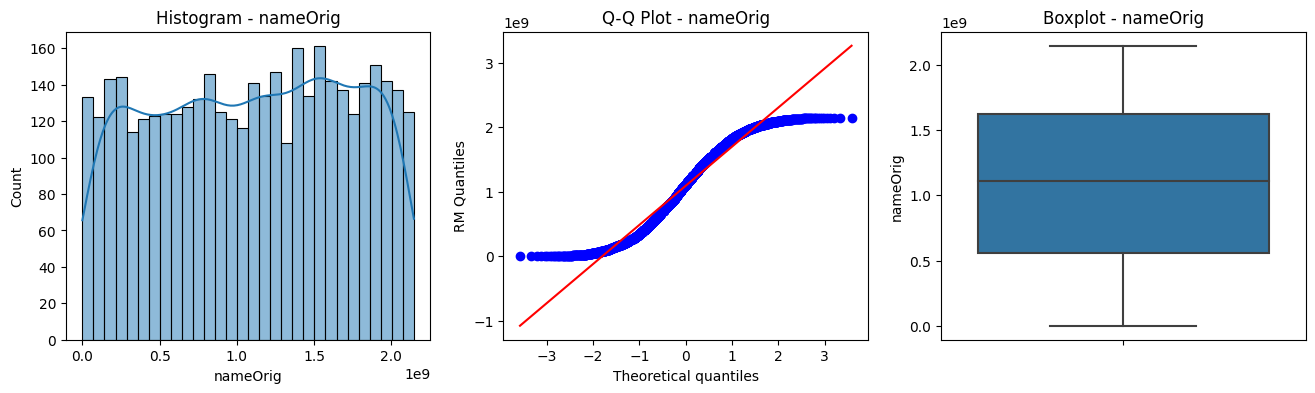

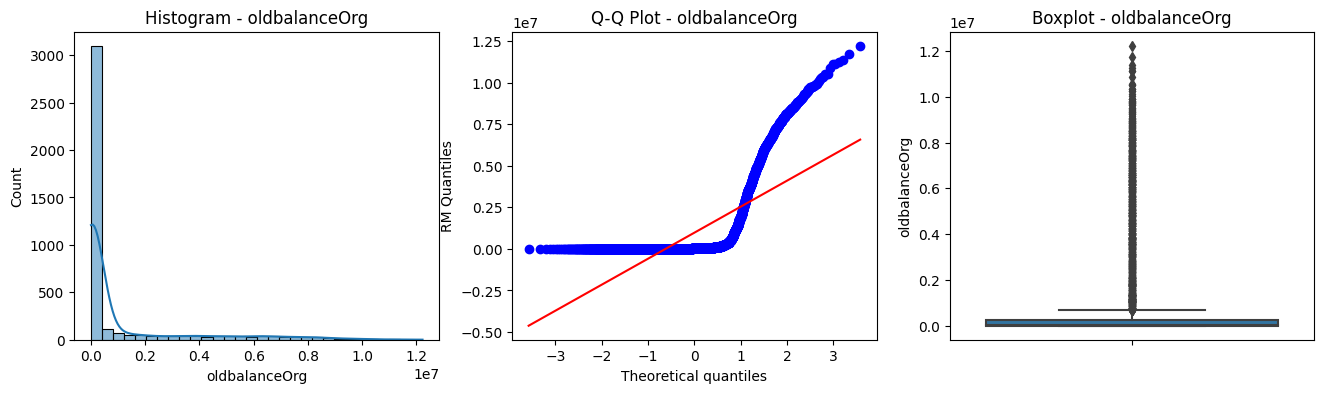

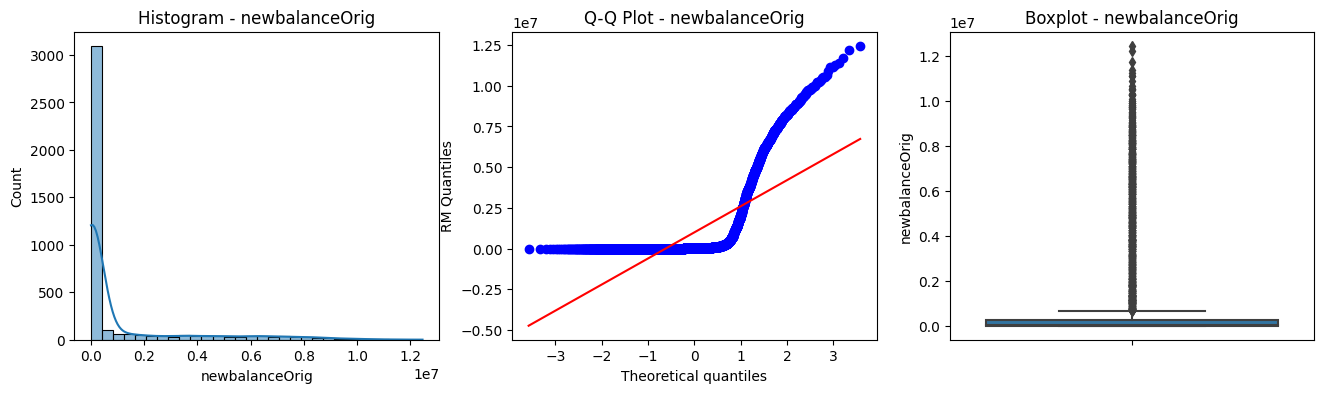

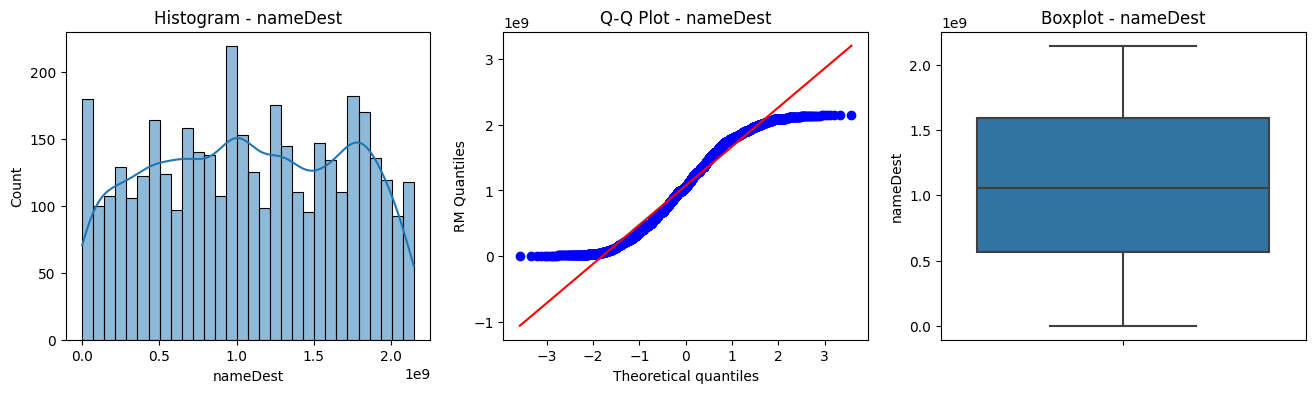

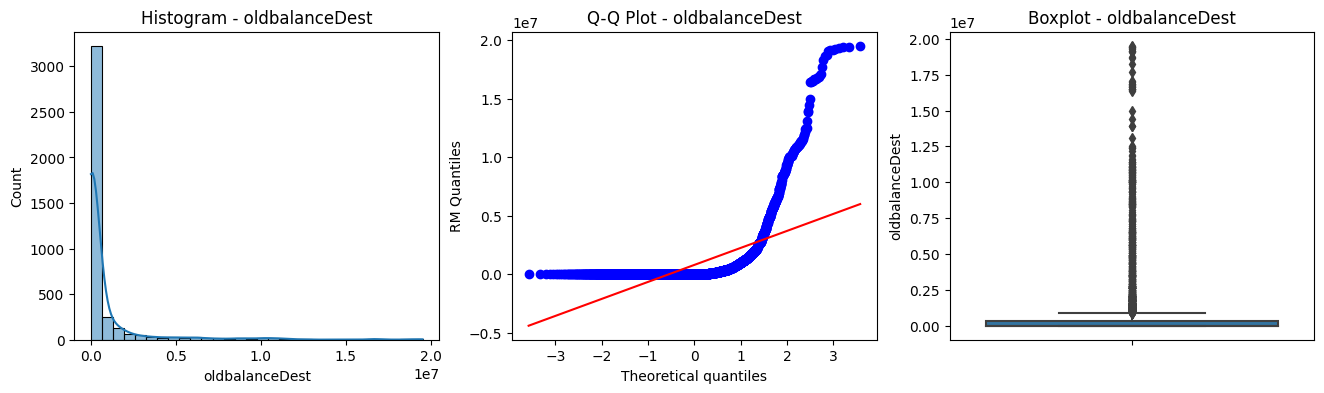

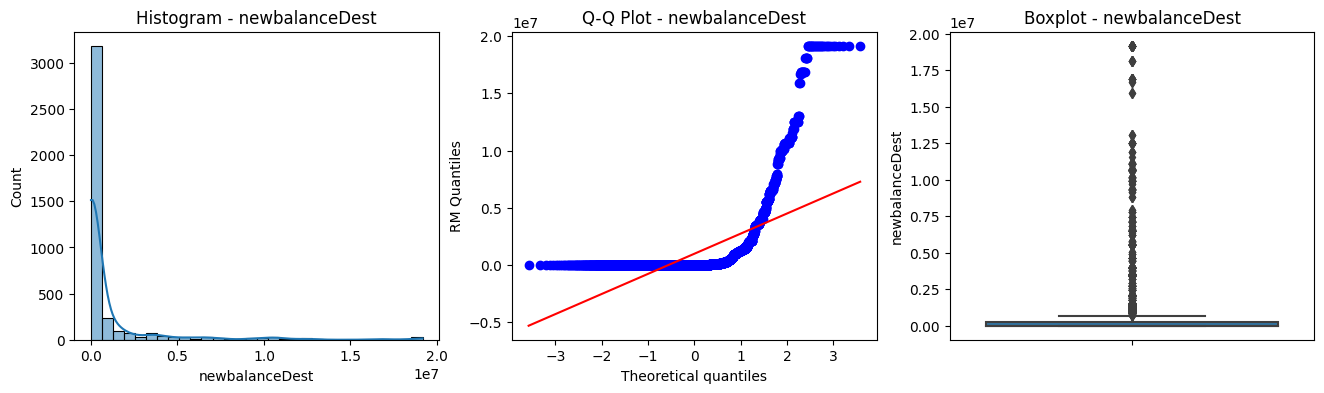

In [76]:
# Run diagnostic plots to explore distributions and check for outliers

def diagnostic_plots(dataframe, variable):
    plt.figure(figsize=(16, 4))

    plt.subplot(1, 3, 1)
    sns.histplot(dataframe[variable], bins=30, kde=True)
    plt.title(f"Histogram - {variable}")

    plt.subplot(1, 3, 2)
    stats.probplot(dataframe[variable], dist="norm", plot=plt)
    plt.ylabel("RM Quantiles")
    plt.title(f"Q-Q Plot - {variable}")

    plt.subplot(1, 3, 3)
    sns.boxplot(y=dataframe[variable])
    plt.title(f"Boxplot - {variable}")

    plt.show()


for col in continuous_cols.columns:
    diagnostic_plots(df_encoded, col)

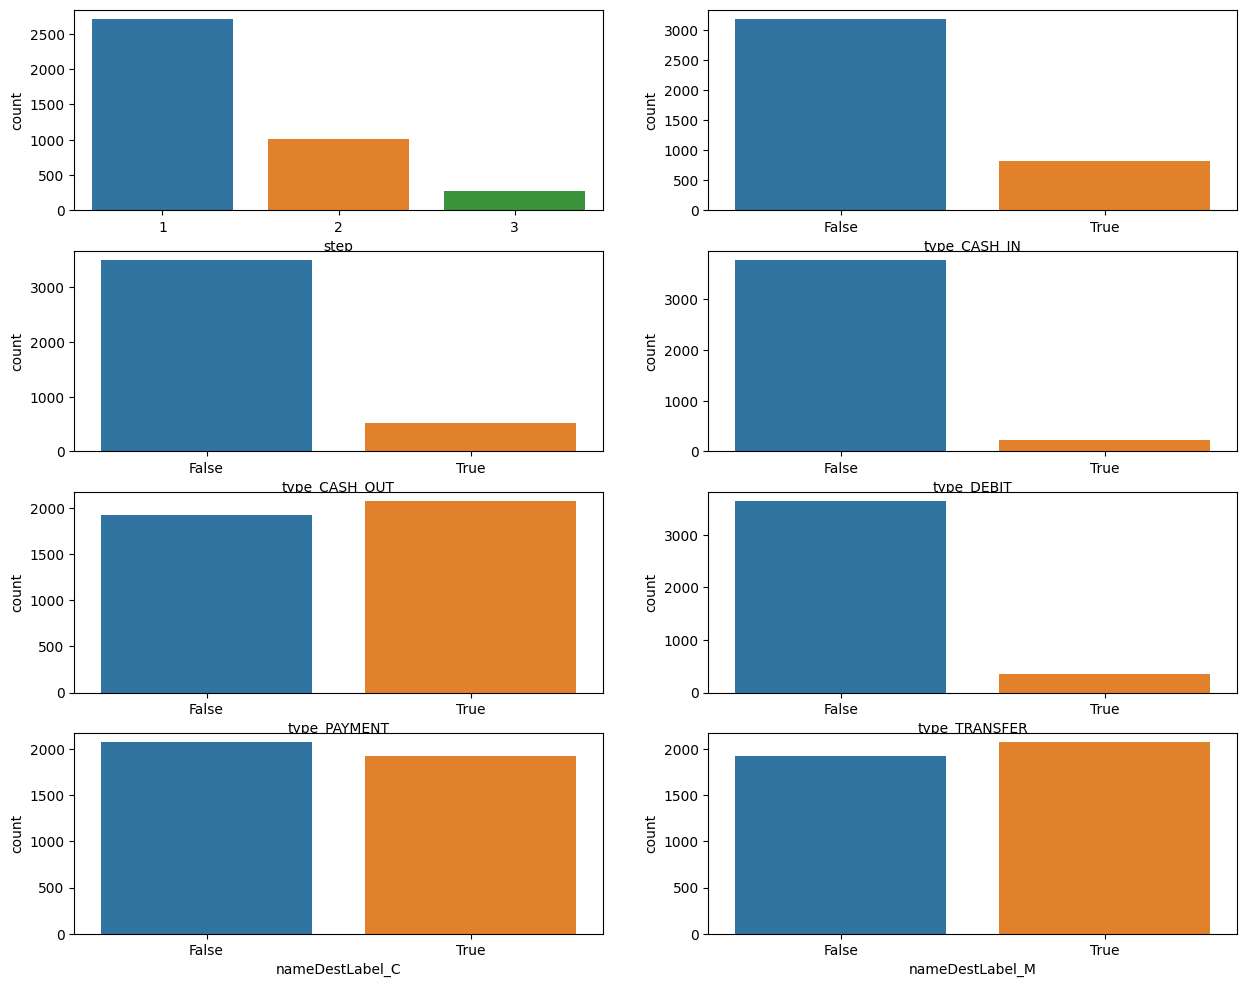

In [77]:
discrete_cols = pd.concat([df_encoded["step"], df_encoded.select_dtypes(include="bool")], axis=1).columns
n = len(discrete_cols)

fig, ax = plt.subplots(math.ceil(n/2), 2, figsize=(15,12), sharey=False)
axes = ax.flatten()

for i in range(n):
    sns.countplot(data=df_encoded, x=discrete_cols[i], ax=axes[i])


In [78]:
# Payment types: Reasonably balanced binary account of type_PAYMENT whereas other false dominates other payment types indicating the predominance of type_PAYMENT 
# Payment destination: Reasonably balanced amounts of customers and merchants as
# Step size: Inverse correlation with transaction length (in hours) and number of transactions.